<a href="https://colab.research.google.com/github/Ignacioelamo/LLMs4Phishing/blob/main/02_feature_engineering%2BLDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pasos previos

## 📦 Instalación de paquetes necesarios

In [1]:
!pip install --upgrade --force-reinstall gensim pyLDAvis spacy nltk pandas


print("✅ Instalación completa. 🔁 Ahora reinicia el entorno manualmente y ejecuta la siguiente celda.")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 524.6 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.2/67.2 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.5/40.5 kB 2.4 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of thinc to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 49.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 50.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.0/33.0 MB 20.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 57.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 91.6 MB

✅ Instalación completa. 🔁 Ahora reinicia el entorno manualmente y ejecuta la siguiente celda.


## 📚 Imports necesarios

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import os
import re
import logging
import warnings
from pprint import pprint

# NLTK
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel, LdaModel
from gensim.models.phrases import Phrases, Phraser

# PyLDAvis
import pyLDAvis
import pyLDAvis.gensim

# spaCy
import spacy

## Reproducibilidad

In [8]:
SEED = 100

random.seed(SEED)
np.random.seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)

## 🔧 Configuración de entorno

In [9]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt_tab')

warnings.filterwarnings("ignore", category=DeprecationWarning)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


 ## 📥 Descargar dataset

In [10]:
NOMBRE_ARCHIVO = 'emails.csv'
!wget https://raw.githubusercontent.com/Ignacioelamo/LLMs4Phishing/main/data/01_combined_cleaned_email_data.csv -O $NOMBRE_ARCHIVO

--2025-05-29 16:52:02--  https://raw.githubusercontent.com/Ignacioelamo/LLMs4Phishing/main/data/01_combined_cleaned_email_data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10064045 (9.6M) [text/plain]
Saving to: ‘emails.csv’

emails.csv          100%[===================>]   9.60M  48.1MB/s    in 0.2s    

2025-05-29 16:52:03 (48.1 MB/s) - ‘emails.csv’ saved [10064045/10064045]



## 📄 Cargar datos

In [11]:
df = pd.read_csv(NOMBRE_ARCHIVO)

# 🧪 Feature Engineering

Vamos a definiar las siguientes características nuevas a partir del cuerpo del correo:

1. **body_html=contains_html**: This is a binary feature that represents the presence of HTML in the email body.  
2. **body_forms**: This binary feature represents the presence of forms in HTML email bodies.
3. **body_noWords**: This feature measures the total number of words occurring in the email.
4.  **body_noCharacters**: This feature measures the total number of characters occurring in the email body.
5.  **body_noDistinctWords**: This feature measures the total number of distinct words occurring in the body of the email.  
6. **body_richness**: The richness is defined as the ratio of the number of words to the number of characters in the document.
$$
\text{body_richness} = \frac{\text{body_noWords}}{\text{body_noCharacters}}
$$
8. **body_noFunctionWords** Chandrasekaran [6] also listed a set of function words that included:  
`account`, `access`, `bank`, `credit`, `click`, `identity`, `inconvenience`, `information`, `limited`, `log`, `minutes`, `password`, `recently`, `risk`, `social`, `security`, `service`, and `suspended`.  The `body_noFunctionWords` feature measures the total number of occurrences of these function words in the email body.
9. **body_suspension** This binary feature represents the presence of the word **"suspension"** in the body of the email.  
10.  **body_verifyYourAccount** This binary feature represents the presence of the phrase **"verify your account"** in the body of the email.
11. **body_text** contains information regarding the context and purpose of an email. For this, we extract the plain text from the email body and use word embedding techniques to represent it.

Añadimos las features que ya teníamos: **has_attachment**, **contains_html**, **urls**.

In [12]:
df = (
    pd.read_csv(NOMBRE_ARCHIVO)
      .assign(
          # Feature 3: body_noWords (Total number of words)
          body_noWords=lambda df: df['body'].apply(lambda x: len(str(x).split())),

          # Feature 4: body_noCharacters (Total number of characters)
          body_noCharacters=lambda df: df['body'].apply(lambda x: len(str(x))),

          # Feature 5: body_noDistinctWords (Total number of distinct words)
          body_noDistinctWords=lambda df: df['body'].apply(lambda x: len(set(str(x).split()))),

          # Feature 6: body_richness (Ratio of words to characters)
          body_richness=lambda df: df['body'].apply(lambda x: len(str(x).split())) / df['body'].apply(lambda x: len(str(x))),

          # Feature 7: body_noFunctionWords (Count of specific function words)
          body_noFunctionWords=lambda df: df['body'].apply(
              lambda x: sum(1 for word in str(x).split()
                          if word.lower() in ['account', 'access', 'bank', 'credit', 'click',
                                            'identity', 'inconvenience', 'information', 'limited',
                                            'log', 'minutes', 'password', 'recently', 'risk',
                                            'social', 'security', 'service', 'suspended'])
          )
      )
)

# LDA

Es un modelo generativo de tópicos sobre Bag-of-Words, que descubre distribuciones de palabras

## 🧹 Preprocesamiento de texto

In [13]:
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'http', 'www'])

data = df['body'].astype(str).tolist()

# Limpieza básica
data = [re.sub(r'\S*@\S*\s?', '', sent) for sent in data]
data = [re.sub(r'http\S+|www\S+|https\S+', '', sent, flags=re.MULTILINE) for sent in data]
data = [' '.join(sent.replace('\n', ' ').replace('\r', ' ').split()) for sent in data]
data = [sent.replace("'", "") for sent in data]
data = [re.sub(r'[^a-zA-Z\s]', '', sent) for sent in data]
data = [re.sub(r'\b\d+\b', '', sent) for sent in data]

# Eliminar tokens alfanuméricos con exceso de números
data = [
    ' '.join([
        word for word in sent.split()
        if not (len(word) > 3 and sum(c.isdigit() for c in word) > sum(c.isalpha() for c in word.replace('.', '')))
    ])
    for sent in data
]

data = [
    re.sub(
        r'\b[a-z]*\d+[a-z\d]*\b',
        lambda m: '' if len(m.group(0)) > 5 and sum(c.isdigit() for c in m.group(0)) > sum(c.isalpha() for c in m.group(0)) / 2 else m.group(0),
        sent
    )
    for sent in data
]


## 🧾 Tokenización y lematización

In [14]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield gensim.utils.simple_preprocess(str(sentence), deacc=True)

data_words = list(sent_to_words(data))

bigram = Phrases(data_words, min_count=5, threshold=100)
trigram = Phrases(bigram[data_words], threshold=100)
bigram_mod = Phraser(bigram)
trigram_mod = Phraser(trigram)

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

data_words_nostops = remove_stopwords(data_words)
data_words_bigrams = make_bigrams(data_words_nostops)


nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

data_lemmatized = lemmatization(data_words_bigrams)

/usr/local/lib/python3.11/dist-packages/spacy/util.py:922: UserWarning: [W095] Model 'en_core_web_sm' (3.7.1) was trained with spaCy v3.7.2 and may not be 100% compatible with the current version (3.8.7). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


## 📚 LDA Topic Modeling


Creamos el corpus

In [16]:
id2word = corpora.Dictionary(data_lemmatized)
id2word.filter_extremes(no_below=5, no_above=0.7)

texts = data_lemmatized
corpus = [id2word.doc2bow(text) for text in texts]

Miramos la coherencia cambiando el número de tópicos y el tipo de alpha = `['symmetric', 'asymmetric', 'auto']`

Calculando coherencia para alpha='symmetric'...


Calculando coherencia para alpha='asymmetric'...


Calculando coherencia para alpha='auto'...


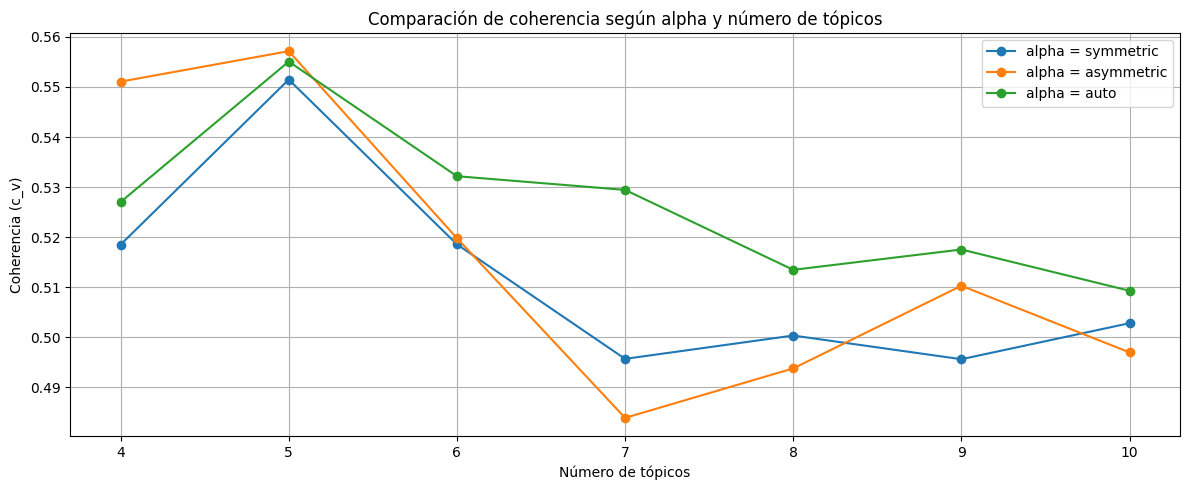

In [8]:
def compute_coherence_values(alpha_value):
    coherence_scores = []
    topic_range = range(4, 11)
    for num_topics in topic_range:
        model = LdaModel(
            corpus=corpus,
            id2word=id2word,
            num_topics=num_topics,
            random_state=SEED,
            update_every=1,
            chunksize=1000,
            passes=30,
            iterations=400,
            alpha=alpha_value,
            eta='auto',
            per_word_topics=True
        )
        coherence_model = CoherenceModel(model=model, texts=texts, dictionary=id2word, coherence='c_v')
        coherence_scores.append(coherence_model.get_coherence())
    return list(topic_range), coherence_scores

alphas = ['symmetric', 'asymmetric', 'auto']
results = {}

for alpha in alphas:
    print(f"Calculando coherencia para alpha='{alpha}'...")
    x, y = compute_coherence_values(alpha)
    results[alpha] = (x, y)

plt.figure(figsize=(12, 5))
for alpha in alphas:
    plt.plot(results[alpha][0], results[alpha][1], marker='o', label=f"alpha = {alpha}")
plt.title("Comparación de coherencia según alpha y número de tópicos")
plt.xlabel("Número de tópicos")
plt.ylabel("Coherencia (c_v)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



## Entrenamos el modelo final

Al final de varias pruebas jugando con los hiperparámetros nos decantamos por 6 tópicos y con `alpha='asymmetric'`

In [17]:
lda_model = LdaModel(
    corpus=corpus,
    id2word=id2word,
    num_topics=6,
    random_state=SEED,
    update_every=1,
    chunksize=1000,
    passes=30,
    iterations=400,
    alpha='asymmetric',
    eta='auto',
    per_word_topics=True
)

## 📊 Visualización de Tópicos

In [18]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.006610 -0.062710       1        1  23.480400
2     -0.055916 -0.236881       2        1  21.939772
0      0.074988  0.080587       3        1  19.803329
3      0.320629  0.016592       4        1  14.162732
4     -0.205311 -0.067581       5        1  13.481241
5     -0.141000  0.269993       6        1   7.132525, topic_info=        Term         Freq        Total Category  logprob  loglift
338  account  3518.000000  3518.000000  Default  30.0000  30.0000
138    email  4610.000000  4610.000000  Default  29.0000  29.0000
167  receive  2633.000000  2633.000000  Default  28.0000  28.0000
369      org  2268.000000  2268.000000  Default  27.0000  27.0000
284    write  2840.000000  2840.000000  Default  26.0000  26.0000
..       ...          ...          ...      ...      ...      ...
17      time   329.068141  2215.556103   Topic6  -4.6589   0.7335
661      pay   205.412651   555.113419   Topic6  -5.1301   1.6464
136     dear   201.562508  1054.298469   Topic6  -5.1491   0.9860
393   secure   194.961639   597.323692   Topic6  -5.1823   1.5208
39       get   192.187886  3495.745060   Topic6  -5.1967  -0.2603

[404 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
1302      2  0.068460   access
1302      3  0.396495   access
1302      4  0.533414   access
338       4  0.999886  account
3340      3  0.993528   active
...     ...       ...      ...
284       3  0.150317    write
238       1  0.602683     year
238       5  0.396553     year
1168      3  0.029382    young
1168      5  0.969602    young

[688 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 3, 1, 4, 5, 6])

## Análisis de Clustering de Correos Usando LDA (6 Tópicos)

Se ha realizado un modelo de **Latent Dirichlet Allocation (LDA)** con 6 tópicos para agrupar correos electrónicos (algunos de phishing y otros legítimos). A continuación, se describe el contenido temático de cada tópico generado.

---

### 🔹 **Tópico 1: Estafas financieras y solicitudes sospechosas**
**Palabras clave:**  
`"fund", "contact", "business", "make", "money", "country", "call", "send", "need", "transfer", "language", "number", "give", "thank", "detail", "let", "information", "day"`

**Interpretación:**  
Correos asociados a **estafas tradicionales**, como promesas de inversión, traspasos bancarios o solicitudes de ayuda financiera.  
➡️ **Alta probabilidad de phishing.**

---

### 🔹 **Tópico 2: Listas de correo y foros técnicos**
**Palabras clave:**  
`"write", "org", "list", "file", "use", "get", "help", "com", "net", "code", "perl", "work", "think", "mail", "try", "run", "problem", "test", "lists_sourceforge", "message"`

**Interpretación:**  
Mensajes relacionados con **comunidades técnicas, listas de distribución** o colaboración en proyectos de software. Muchas palabras técnicas (`perl`, `code`, `file`) y referencias a listas (`sourceforge`, `list`).  
➡️ **Muy probablemente legítimos.**

---
### 🔹  **Tópico 3: Promociones y recompensas digitales**
**Palabras clave:**  
`"email", "com", "receive", "click", "get", "free", "company", "unsubscribe", "remove", "wallet", "reward", "claim", "offer", "see", "send", "network", "today"`

**Interpretación:**  
Correos con lenguaje promocional que incluyen **ofertas, recompensas, solicitudes de clics o suscripciones**. Presencia de palabras como `reward`, `wallet`, `claim` sugiere posibles campañas de spam o *phishing* promocional.  
➡️ **Alto riesgo de spam o phishing.**

---

### 🔹 **Tópico 4: Notificaciones de cuentas y servicios**
**Palabras clave:**  
`"account", "email", "update", "message", "user", "mail", "address", "information", "receive", "thank", "click", "team", "new", "send", "service", "verify", "security", "change", "customer", "activity"`

**Interpretación:**  
Mensajes automáticos relacionados con **cuentas de usuario**, actualizaciones, verificaciones y actividad en servicios online.  
➡️ **Mixto: incluye tanto correos legítimos como intentos de phishing bien diseñados.**
---

### 🔹 **Tópico 5: Conversaciones personales o informales**
**Palabras clave:**  
`"know", "get", "well", "time", "man", "rpm", "work", "take", "say", "want", "year", "com", "go", "make", "good", "many", "people", "day", "try", "look"`

**Interpretación:**  
Correos con tono conversacional, posiblemente entre conocidos, usuarios frecuentes o interacciones casuales.  
➡️ **Generalmente legítimos.**

---

### 🔹 **Tópico 6: Publicidad comercial y ventas**
**Palabras clave:**  
`"price", "com", "offer", "site", "money", "order", "low", "save", "software", "product", "good", "online", "time", "check", "buy", "customer", "visit", "purchase", "discount", "life"`

**Interpretación:**  
Contenido promocional o publicitario centrado en **productos, ofertas y descuentos**, posiblemente acompañado de enlaces de compra.  
➡️ **Mixto: puede ser spam comercial legítimo o phishing disfrazado de oferta.**

---

## 🛡️ Aplicación para Detección de Phishing

Según la segmentación actual:

- 🔴 **Alta sospecha de phishing:** Tópicos **1** y **3**
- 🟡 **Potencialmente mixtos o ambiguos:** Tópicos **4** y **6**
- 🟢 **Probablemente legítimos:** Tópicos **2** y **5**

## Ver palabras clave por tópico

In [19]:
pprint(lda_model.print_topics(num_words=20))
doc_lda = lda_model[corpus]

[(0,
  '0.030*"email" + 0.018*"com" + 0.018*"receive" + 0.017*"click" + 0.012*"get" '
  '+ 0.011*"free" + 0.011*"company" + 0.009*"unsubscribe" + 0.007*"remove" + '
  '0.007*"new" + 0.007*"wallet" + 0.006*"reward" + 0.006*"claim" + '
  '0.006*"name" + 0.005*"service" + 0.005*"offer" + 0.005*"see" + 0.005*"send" '
  '+ 0.005*"network" + 0.005*"today"'),
 (1,
  '0.012*"fund" + 0.009*"contact" + 0.008*"business" + 0.007*"make" + '
  '0.007*"money" + 0.007*"country" + 0.007*"call" + 0.007*"send" + '
  '0.007*"need" + 0.006*"know" + 0.006*"transfer" + 0.006*"language" + '
  '0.006*"number" + 0.006*"give" + 0.005*"thank" + 0.005*"detail" + '
  '0.005*"name" + 0.005*"let" + 0.005*"information" + 0.005*"day"'),
 (2,
  '0.021*"write" + 0.020*"org" + 0.013*"list" + 0.012*"file" + 0.011*"use" + '
  '0.010*"get" + 0.009*"help" + 0.009*"com" + 0.009*"net" + 0.009*"code" + '
  '0.008*"perl" + 0.008*"work" + 0.007*"think" + 0.007*"mail" + 0.006*"try" + '
  '0.006*"run" + 0.006*"problem" + 0.006*"test